In [1]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms

## Grab the test data and visualise

In [2]:
data_path = "/home/sravula/experiments/datasets/8047_vel_imgs.npy"

In [3]:
from datasets.velocity_fine import Velocity

tran_transform = transforms.Compose([
    transforms.Resize([256, 256])
])

dataset = Velocity(path=data_path, transform=tran_transform)

In [4]:
N = len(dataset)
indices = list(range(N))
random_state = np.random.get_state()
np.random.seed(2240)
np.random.shuffle(indices)
np.random.set_state(random_state)
train_indices, test_indices = indices[:int(N * 0.9)], indices[int(N * 0.9):]

In [5]:
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [6]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=25, shuffle=False,
                         num_workers=8, drop_last=True)

test_iter = iter(test_loader)

test_sample = next(test_iter)[0]

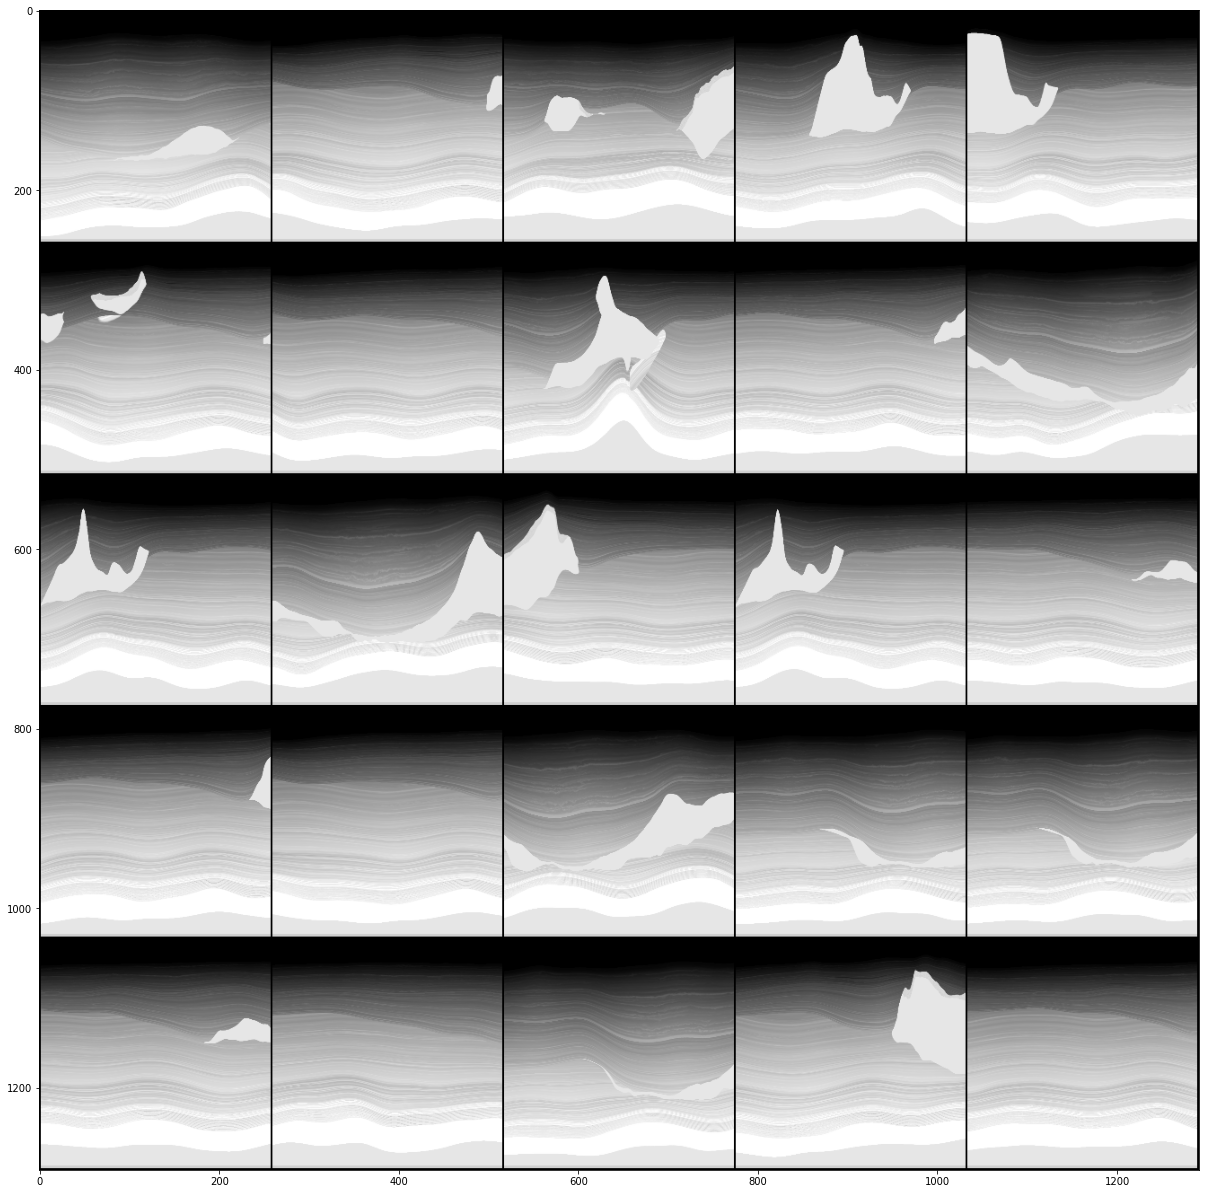

In [7]:
grid_img = torchvision.utils.make_grid(test_sample, nrow=5)

dpi = matplotlib.rcParams['figure.dpi']

height = width = 6*256
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Noise the test data and visualise

In [8]:
noisy_test_sample = test_sample + 0.3*torch.randn(test_sample.size())
noisy_test_sample = torch.clip(noisy_test_sample, min=0, max=1)

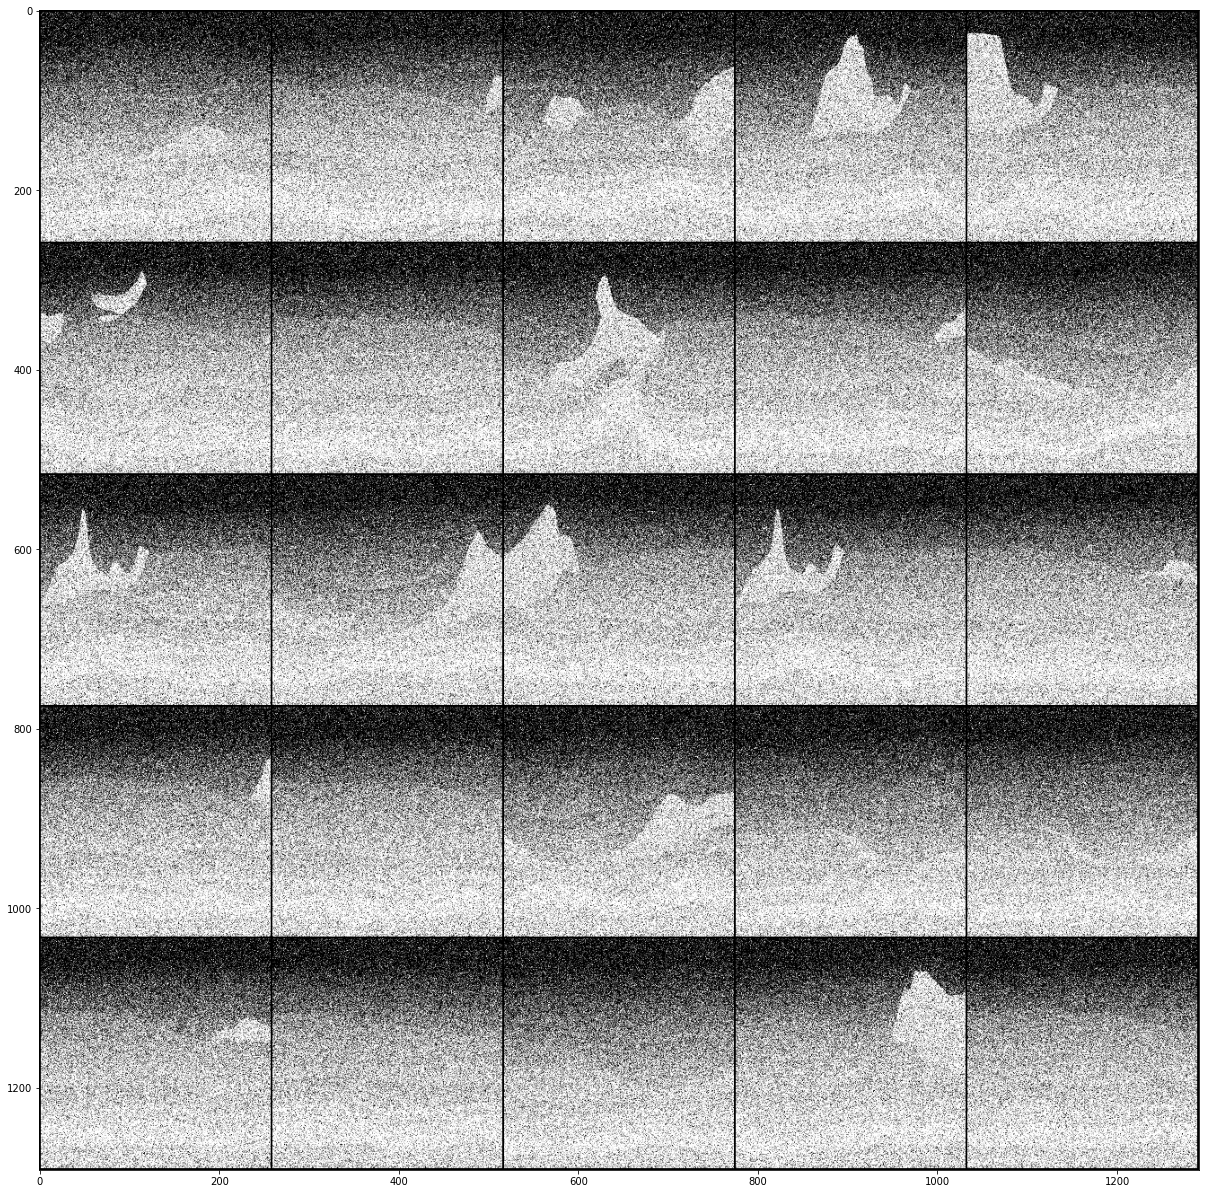

In [9]:
grid_img = torchvision.utils.make_grid(noisy_test_sample, nrow=5)

dpi = matplotlib.rcParams['figure.dpi']

height = width = 6*256
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Load the network and perform Langevin dynamics on the noisy images

In [10]:
ckpt_path = "/home/sravula/experiments/logs/run_2/checkpoint.pth"
config_path = "/home/sravula/ncsnv2/configs/velocity.yml"

In [11]:
import argparse
from main import dict2namespace
import yaml

with open(config_path, 'r') as f:
    config = yaml.load(f)
new_config = dict2namespace(config)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
new_config.device = device

print(device)

/home/sravula/venvs/ncsnv2/lib64/python3.6/site-packages/ipykernel_launcher.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


cuda


In [12]:
from models.ncsnv2 import NCSNv2Deepest
from models.ema import EMAHelper
from models import get_sigmas

new_config.input_dim = new_config.data.image_size ** 2 * new_config.data.channels

score = NCSNv2Deepest(new_config).to(new_config.device)
score = torch.nn.DataParallel(score)

#Set up the exponential moving average
if new_config.model.ema:
    ema_helper = EMAHelper(mu=new_config.model.ema_rate)
    ema_helper.register(score)

states = torch.load(ckpt_path)
score.load_state_dict(states[0])
### Make sure we can resume with different eps
states[1]['param_groups'][0]['eps'] = new_config.optim.eps

if new_config.model.ema:
    ema_helper.load_state_dict(states[4])

#grab all L noise levels
sigmas = get_sigmas(new_config)

In [13]:
test_score = ema_helper.ema_copy(score)

test_score.eval()

DataParallel(
  (module): NCSNv2Deepest(
    (act): ELU(alpha=1.0)
    (begin_conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (normalizer): InstanceNorm2dPlus(
      (instance_norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (end_conv): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res1): ModuleList(
      (0): ResidualBlock(
        (non_linearity): ELU(alpha=1.0)
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (normalize2): InstanceNorm2dPlus(
          (instance_norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (normalize1): InstanceNorm2dPlus(
          (instance_norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
      )
      (1): Resid

In [14]:
from models import langevin_Inverse
import time

N, C, H, W = noisy_test_sample.shape
print(N, C, H, W)

y = noisy_test_sample.to(new_config.device)

#A = torch.eye(C*H*W, device=new_config.device, dtype=torch.bool)

x0 = torch.rand(N, C, H, W, device=new_config.device)

start = time.time()

all_samples = langevin_Inverse(x_mod = x0, 
                                       y = y, 
                                       A = None, 
                                       scorenet = test_score, 
                                       sigmas = sigmas.cpu().numpy(), 
                                       n_steps_each=1,
                                       step_lr=new_config.sampling.step_lr,
                                       final_only=True, 
                                       verbose=True,
                                       denoise=False,
                                       add_noise=False, 
                                       decimate_sigma=1100//50,
                                       mode='denoising',
                                       true_x=test_sample.to(new_config.device))

print("\nTOTAL TIME: ", time.time() - start)

25 1 256 256


/home/sravula/venvs/ncsnv2/lib64/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



level: 0, step_size: 5.0000, prior_norm: 3.4064, likelihood_norm: 4.7431, grad_norm: 7.5034                             image_norm: 140.5147, snr: inf, prior_mean_norm: 0.0001, likelihood_mean_norm: 8.6425, grad_mean_norm: 12.3832, train_mse: 0.2146
 true_mse: 0.1146

level: 1, step_size: 4.8384, prior_norm: 3.4648, likelihood_norm: 3.3631, grad_norm: 5.6932                             image_norm: 140.9780, snr: inf, prior_mean_norm: 0.0001, likelihood_mean_norm: 5.0603, grad_mean_norm: 7.1574, train_mse: 0.1079
 true_mse: 0.0686

level: 2, step_size: 4.6821, prior_norm: 3.5010, likelihood_norm: 2.5270, grad_norm: 3.9352                             image_norm: 144.1834, snr: inf, prior_mean_norm: 0.0001, likelihood_mean_norm: 3.0735, grad_mean_norm: 4.2262, train_mse: 0.0609
 true_mse: 0.0460

level: 3, step_size: 4.5308, prior_norm: 3.4824, likelihood_norm: 2.2646, grad_norm: 2.4053                             image_norm: 147.5824, snr: inf, prior_mean_norm: 0.0001, likelihood_mean_n


level: 31, step_size: 1.8062, prior_norm: 4.3384, likelihood_norm: 2.1064, grad_norm: 2.3491                             image_norm: 165.1199, snr: inf, prior_mean_norm: 0.0001, likelihood_mean_norm: 0.1781, grad_mean_norm: 0.2233, train_mse: 0.0423
 true_mse: 0.0054

level: 32, step_size: 1.7478, prior_norm: 3.0228, likelihood_norm: 2.2587, grad_norm: 1.6039                             image_norm: 165.1779, snr: inf, prior_mean_norm: 0.0000, likelihood_mean_norm: 0.2044, grad_mean_norm: 0.1429, train_mse: 0.0487
 true_mse: 0.0054

level: 33, step_size: 1.6914, prior_norm: 3.6324, likelihood_norm: 2.2769, grad_norm: 4.3118                             image_norm: 165.3406, snr: inf, prior_mean_norm: 0.0001, likelihood_mean_norm: 0.2078, grad_mean_norm: 0.8371, train_mse: 0.0495
 true_mse: 0.0059

level: 34, step_size: 1.6367, prior_norm: 4.3407, likelihood_norm: 2.1212, grad_norm: 3.3228                             image_norm: 165.3014, snr: inf, prior_mean_norm: 0.0001, likelihood_mea

In [15]:
sample = all_samples[-1].view(all_samples[-1].shape[0], new_config.data.channels,
                              new_config.data.image_size,
                              new_config.data.image_size)

sample = torch.clamp(sample, 0.0, 1.0)

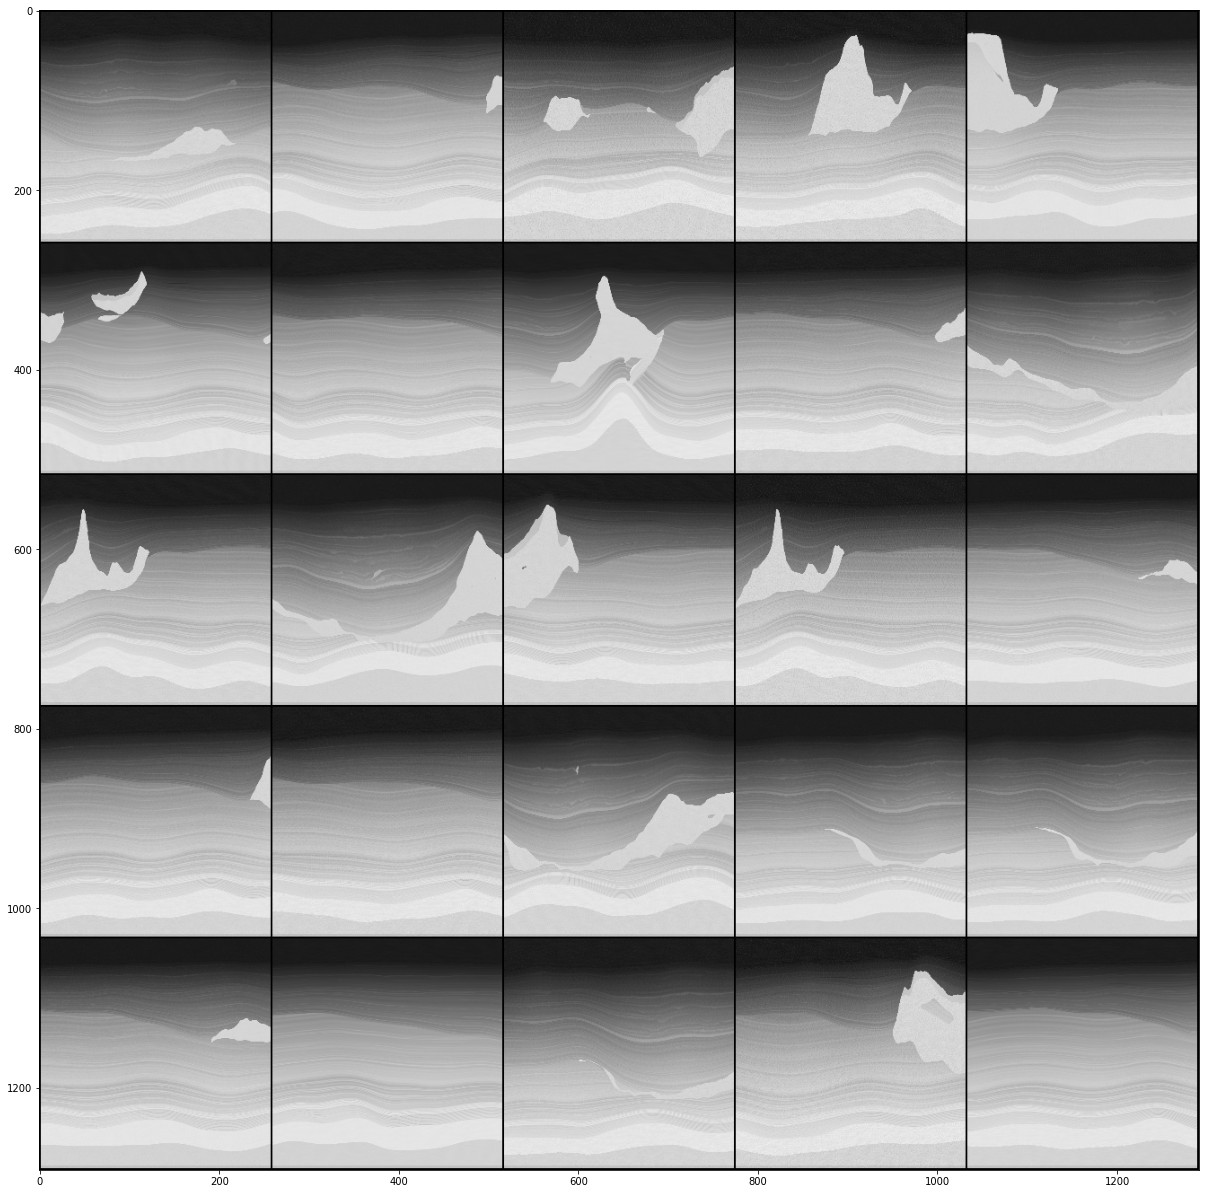

In [16]:
grid_img = torchvision.utils.make_grid(sample, nrow=5)

dpi = matplotlib.rcParams['figure.dpi']

height = width = 6*256
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()